# Random Forest on DGM Features (Leave-One-User-Out)



In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)



In [2]:
# Paths and constants - Using relative paths to find project root
# Get the project root directory by looking for "Code" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Code" folder exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Code")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Convert to Path objects
base_dir = Path(project_root)
dgm_dir = base_dir / "non-contaminated datasets" / "DGMs"
target_csv_path = base_dir / "Code" / "Utilities" / "users_literacy_results.csv"

# Print paths for verification
print(f"Project root: {project_root}")
print(f"DGM directory: {dgm_dir}")
print(f"CSV path: {target_csv_path}")

# Columns with pervasive NaNs to drop
nan_columns = [
    "mean_peak_saccade_velocity", "median_peak_saccade_velocity", "std_peak_saccade_velocity",
    "min_peak_saccade_velocity", "max_peak_saccade_velocity", "mean_mean_saccade_velocity",
    "median_mean_saccade_velocity", "std_mean_saccade_velocity", "min_mean_saccade_velocity",
    "max_mean_saccade_velocity", "average_blink_rate_per_minute", "stdev_of_relative_degrees",
]

# Load literacy labels
literacy_df = pd.read_csv(target_csv_path)
literacy_df["MEDIA_ID"] = literacy_df["MEDIA_ID"].astype(int)
literacy_df["LITERACY"] = literacy_df["LITERACY"].astype(int)
literacy_map = dict(zip(literacy_df["MEDIA_ID"], literacy_df["LITERACY"]))

skip_users = {5, 20}
graph_types = ["bar", "line", "pie"]

# Tuned Random Forest hyperparameters from prior search
tuned_rf_params = {
    "n_estimators": 50,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": 10,
    "bootstrap": False,
    "random_state": 42,
}



Project root: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research
DGM directory: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\non-contaminated datasets\DGMs
CSV path: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\Code\Utilities\users_literacy_results.csv


In [3]:
def load_graph_dataset(graph_type: str):
    """Return feature matrix, labels, and user groups for a given graph type."""
    records = []
    labels = []
    groups = []

    all_columns = set()

    graph_path = dgm_dir / graph_type
    literacy_levels = ["literate", "illiterate"]

    for literacy_level in literacy_levels:
        level_path = graph_path / literacy_level
        if not level_path.exists():
            continue

        for user_dir in sorted(level_path.glob("user_*")):
            try:
                user_id = int(user_dir.name.split("_")[1])
            except (IndexError, ValueError):
                continue

            if user_id in skip_users:
                continue

            label = literacy_map.get(user_id)
            if label is None:
                continue

            for csv_file in sorted(user_dir.glob("*_DGMs.csv")):
                df = pd.read_csv(csv_file)
                df_clean = df.drop(columns=nan_columns, errors="ignore")

                if df_clean.empty:
                    continue

                row = df_clean.iloc[0]
                row = pd.to_numeric(row, errors="coerce")

                records.append(row)
                labels.append(label)
                groups.append(user_id)
                all_columns.update(row.index)

    if not records:
        return pd.DataFrame(), pd.Series(dtype=int), np.array([])

    all_columns = sorted(all_columns)
    X = pd.DataFrame([record.reindex(all_columns) for record in records], columns=all_columns)
    y = pd.Series(labels, name="literacy")
    groups = np.array(groups)

    return X, y, groups



In [4]:
def run_leave_one_user_out(X, y, groups):
    """Run LOUO random forest and return aggregate metrics and per-user results."""
    logo = LeaveOneGroupOut()

    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(**tuned_rf_params)),
    ])

    user_scores = {}
    user_confusions = {}
    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in logo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        test_users = np.unique(groups[test_idx])
        for user in test_users:
            user_mask = groups[test_idx] == user
            y_true_user = y_test[user_mask]
            y_pred_user = y_pred[user_mask]

            user_scores[user] = accuracy_score(y_true_user, y_pred_user)
            cm = confusion_matrix(y_true_user, y_pred_user, labels=[0, 1])
            user_confusions[user] = cm

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    overall_accuracy = accuracy_score(y_true_all, y_pred_all)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_all,
        y_pred_all,
        average="binary",
        zero_division=0,
    )

    return overall_accuracy, precision, recall, f1, user_scores, user_confusions



In [5]:
results = {}

for graph in graph_types:
    X, y, groups = load_graph_dataset(graph)
    print(f"Graph type: {graph}")
    print(f"  Samples: {len(X)} | Features: {X.shape[1]} | Users: {len(np.unique(groups))}")

    if len(X) == 0:
        print("  No data found. Skipping.\n")
        continue

    overall_acc, precision, recall, f1, user_scores, user_confusions = run_leave_one_user_out(X, y, groups)
    results[graph] = {
        "overall_accuracy": overall_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "user_scores": user_scores,
        "user_confusions": user_confusions,
    }

    print(
        f"  Leave-One-User-Out Accuracy: {overall_acc:.3f} | "
        f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}\n"
    )



Graph type: bar
  Samples: 779 | Features: 50 | Users: 30
  Leave-One-User-Out Accuracy: 0.474 | Precision: 0.374 | Recall: 0.317 | F1: 0.343

Graph type: line
  Samples: 570 | Features: 50 | Users: 30
  Leave-One-User-Out Accuracy: 0.500 | Precision: 0.402 | Recall: 0.316 | F1: 0.354

Graph type: pie
  Samples: 150 | Features: 50 | Users: 30
  Leave-One-User-Out Accuracy: 0.560 | Precision: 0.491 | Recall: 0.415 | F1: 0.450



In [6]:
summary_rows = []
for graph, metrics in results.items():
    summary_rows.append({
        "graph_type": graph,
        "overall_accuracy": metrics["overall_accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"],
    })

summary_df = pd.DataFrame(summary_rows).sort_values("graph_type")
summary_df



,graph_type,overall_accuracy,precision,recall,f1
0,bar,0.497436,0.403571,0.334320,0.365696
1,line,0.504394,0.405405,0.303644,0.347222
2,pie,0.366667,0.250000,0.230769,0.240000


In [7]:
# Compute user-level accuracy thresholding at 0.5
user_level_accuracy = {}

for graph_type in graph_types:
    if graph_type not in results:
        continue

    user_scores = results[graph_type]["user_scores"]
    total_users = len(user_scores)
    correct_users = 0
    user_details = []

    for user_id, user_acc in sorted(user_scores.items()):
        is_correct = user_acc > 0.5
        if is_correct:
            correct_users += 1
        user_details.append({
            "user_id": user_id,
            "accuracy": user_acc,
            "correct": is_correct,
        })

    new_accuracy = correct_users / total_users if total_users else 0.0
    user_level_accuracy[graph_type] = {
        "new_accuracy": new_accuracy,
        "correct_users": correct_users,
        "total_users": total_users,
        "user_details": user_details,
    }

    print(f"{graph_type} graphs:")
    print(f"  New Accuracy: {new_accuracy:.3f} ({correct_users}/{total_users} users)")
    print()

summary_user_level = pd.DataFrame([
    {
        "graph_type": graph,
        "new_accuracy": info["new_accuracy"],
        "correct_users": info["correct_users"],
        "total_users": info["total_users"],
    }
    for graph, info in user_level_accuracy.items()
]).sort_values("graph_type")

print("Summary:")
summary_user_level


bar graphs:
  New Accuracy: 0.433 (13/30 users)

line graphs:
  New Accuracy: 0.467 (14/30 users)

pie graphs:
  New Accuracy: 0.333 (10/30 users)

Summary:


,graph_type,new_accuracy,correct_users,total_users
0,bar,0.433333,13,30
1,line,0.466667,14,30
2,pie,0.333333,10,30


In [ ]:
# Inspect per-user accuracy for a specific graph type
graph_type = "bar"

if graph_type in results:
    user_scores = results[graph_type]["user_scores"]
    user_df = (
        pd.DataFrame(
            {
                "user_id": list(user_scores.keys()),
                "accuracy": list(user_scores.values()),
            }
        )
        .sort_values("user_id")
        .reset_index(drop=True)
    )
    display(user_df)
else:
    print(f"Graph type '{graph_type}' not in results.")



,user_id,accuracy
0,1,0.269231
1,2,0.923077
2,3,0.115385
3,4,0.576923
4,6,1.000000
5,7,0.653846
6,8,0.192308
7,9,0.692308
8,10,0.076923
9,11,0.884615


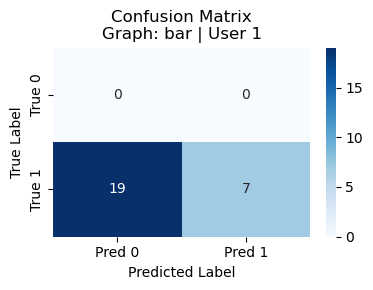

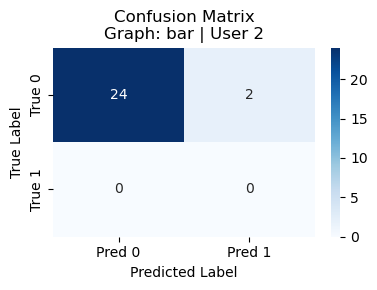

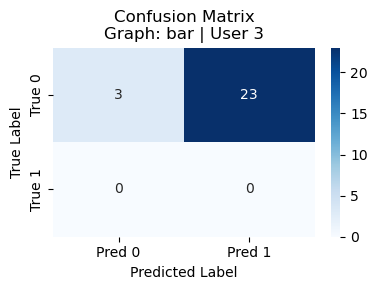

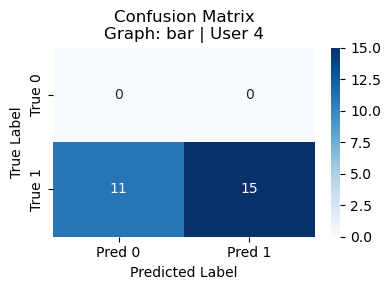

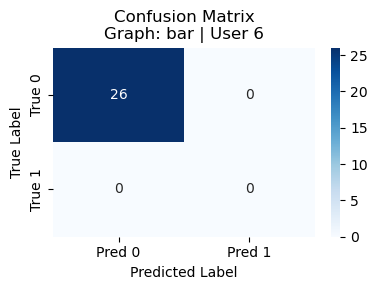

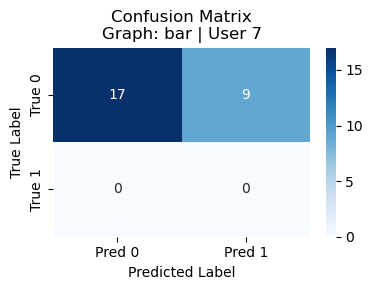

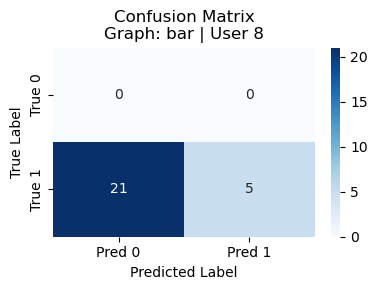

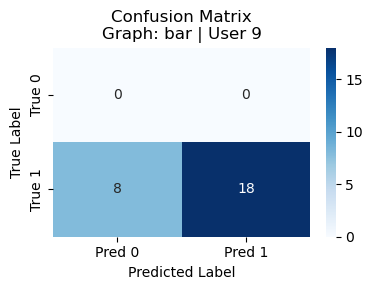

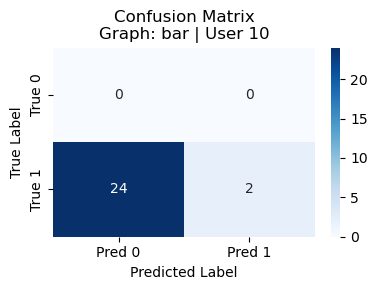

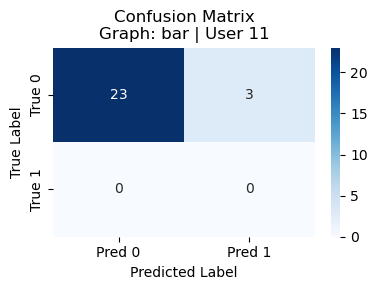

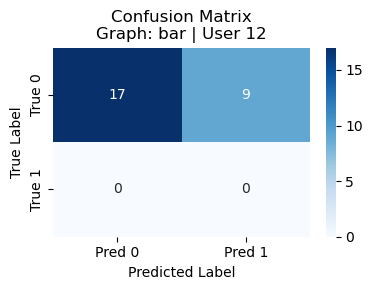

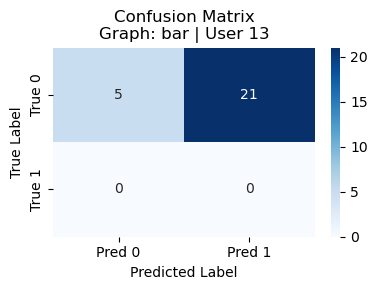

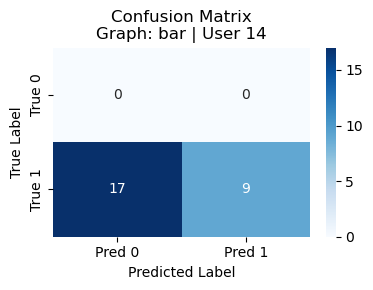

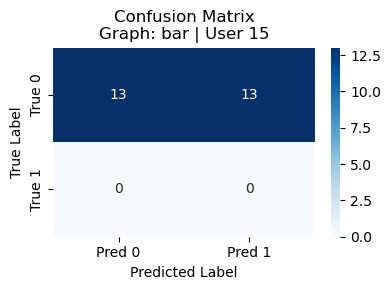

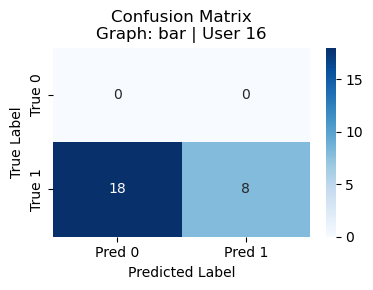

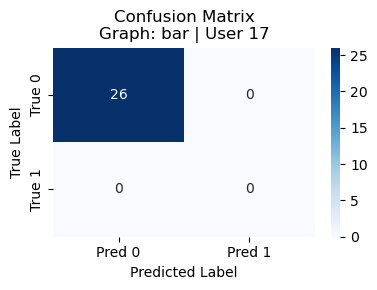

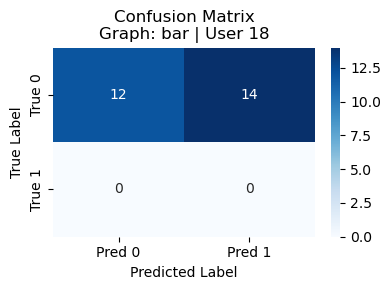

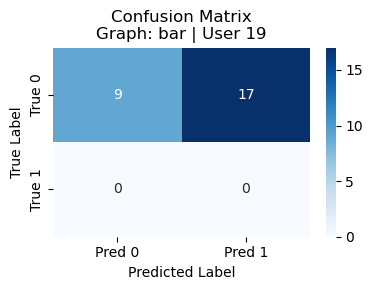

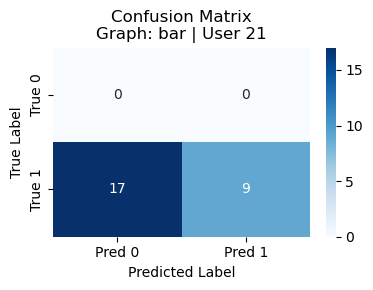

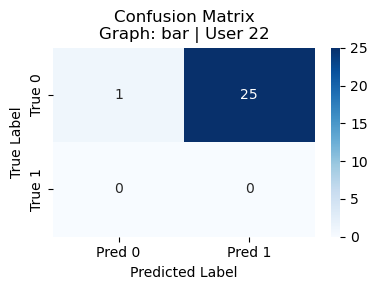

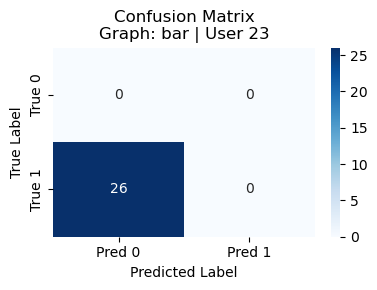

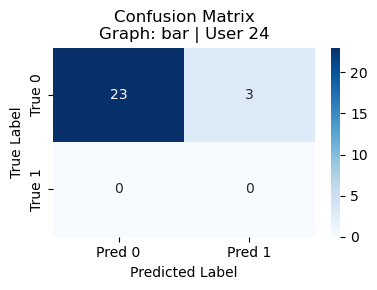

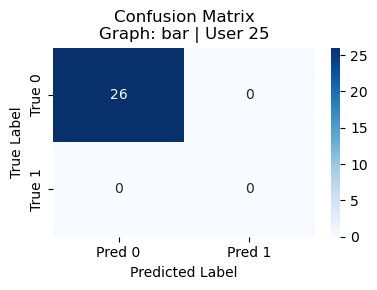

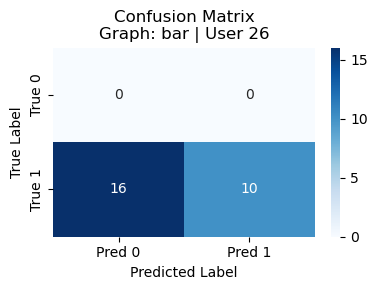

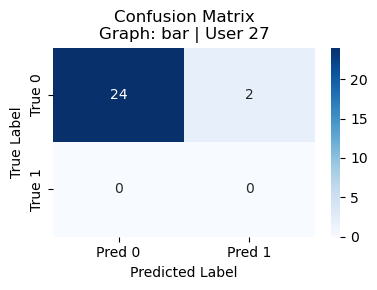

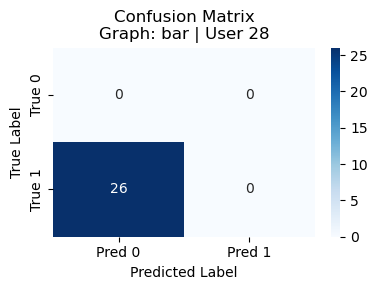

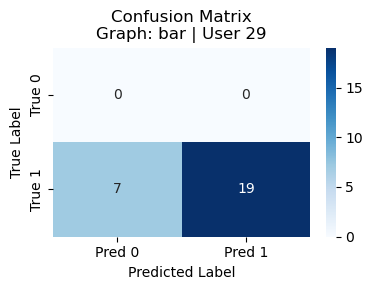

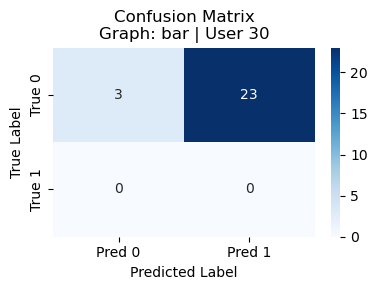

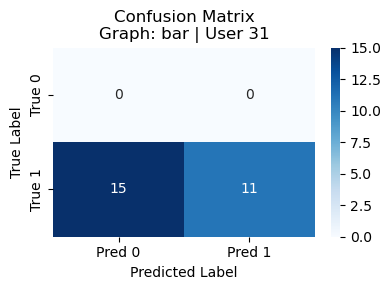

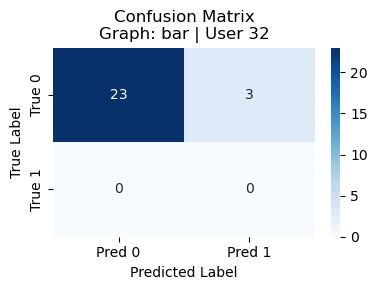

In [9]:
# Plot confusion matrix heatmaps for all users within a graph type
graph_type = "bar"

if graph_type in results:
    user_confusions = results[graph_type]["user_confusions"]
    for user_id in sorted(user_confusions.keys()):
        cm = user_confusions[user_id]
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
        )
        plt.title(f"Confusion Matrix\nGraph: {graph_type} | User {user_id}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.show()
else:
    print(f"Graph type '{graph_type}' not in results.")

